In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-11-28 17:28:37.060220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 17:28:40.500571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    print(df.iloc[0])
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [4]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object
news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object


In [5]:
train_data.head()

,news,masked headline,calculation,ans,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<extra_id_0> K Walmart Part-Timers to Lose Hea...,"Paraphrase(30,000,K)",30,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ex...,Copy(142),142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <extra_id_0> </s>,Copy(94),94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<extra_id_0> M Fine f...,Copy(7),7,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<extra_id_0> K Raised for Kids of Mom Dismemb...,"Paraphrase(222,000,K)",222,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [6]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

In [7]:
#model_name = "Michau/t5-base-en-generate-headline"
#model_name = "MBZUAI/LaMini-Flan-T5-77M"
model_name = "MBZUAI/LaMini-Flan-T5-783M"
#model_name ="czearing/article-title-generator"

In [8]:
def preprocess_function(examples):   
    #inputs = [prefix + doc for doc in examples["news"]]
    inputs = tokenizer(examples['text'],max_length=3066,  truncation=True)
    labels = tokenizer(text_target=examples["calculation"], max_length=248, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
tokenized = dataset.map(preprocess_function, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
#optimizer = AdamWeightDecay(learning_rate=7e-5, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

In [12]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

2023-11-28 11:54:03.868432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2023-11-28 11:54:03.869311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:25:00.0, compute capability: 7.0
/home/u3/hinokicrum/.local/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing th

To convert datasets to the tf.data.Dataset format 

In [13]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
model.compile(optimizer=optimizer)

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(x=tf_train_set, validation_data=tf_test_set,callbacks=[callback],epochs=10)

Epoch 1/10
5641/5641 [==============================] - 2576s 446ms/step - loss: 0.4450 - val_loss: 0.2321
Epoch 2/10
5641/5641 [==============================] - 2508s 445ms/step - loss: 0.2247 - val_loss: 0.1941
Epoch 3/10
5641/5641 [==============================] - 2510s 445ms/step - loss: 0.1722 - val_loss: 0.1845
Epoch 4/10
5641/5641 [==============================] - 2510s 445ms/step - loss: 0.1411 - val_loss: 0.1869


In [16]:
model.save('Lamini28.keras')

/home/u3/hinokicrum/.local/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


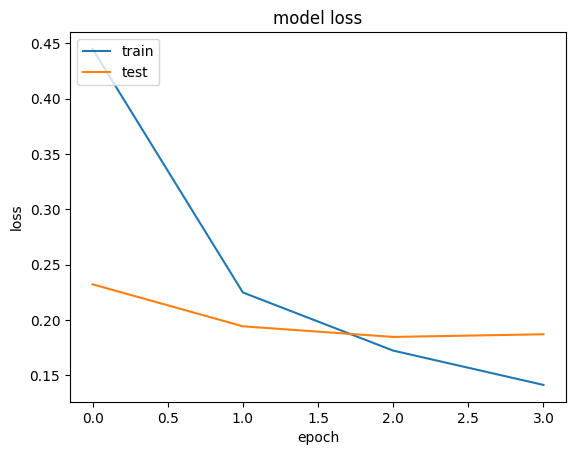

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
model = tf.keras.models.load_model('Lamini28.keras')

2023-11-28 14:45:21.405830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2023-11-28 14:45:21.406516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:25:00.0, compute capability: 7.0
/home/u3/hinokicrum/.local/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


/home/u3/hinokicrum/.local/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [10]:
def preprocess_function2(examples):   
    inputs = tokenizer(examples['calculation'],max_length=400,  truncation=True)
    #labels = tokenizer(text_target=examples["headline"], max_length=128, truncation=True)
    labels = tokenizer(text_target=examples["ans"], max_length=50, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [11]:
tokenized2 = dataset.map(preprocess_function2, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

In [12]:
model2 = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

2023-11-28 17:28:59.354375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2023-11-28 17:28:59.355221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:25:00.0, compute capability: 7.0
/home/u3/hinokicrum/.local/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing th

In [13]:
tf_train_set2 = model2.prepare_tf_dataset(
    tokenized2["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set2 = model2.prepare_tf_dataset(
    tokenized2["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
model2.compile(optimizer=optimizer)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history2 = model2.fit(x=tf_train_set2, validation_data=tf_test_set2,callbacks=[callback], epochs=10)

Epoch 1/10
5641/5641 [==============================] - 1174s 198ms/step - loss: 0.1963 - val_loss: 0.1121
Epoch 2/10
5641/5641 [==============================] - 1125s 199ms/step - loss: 0.1179 - val_loss: 0.1071
Epoch 3/10
5641/5641 [==============================] - 1120s 199ms/step - loss: 0.0976 - val_loss: 0.1019
Epoch 4/10
5641/5641 [==============================] - 1105s 196ms/step - loss: 0.0844 - val_loss: 0.1033


In [15]:
model2.save('Lamini282.keras')

/home/u3/hinokicrum/.local/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [20]:
model2 = tf.keras.models.load_model('Lamini282.keras')

/home/u3/hinokicrum/.local/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


/home/u3/hinokicrum/.local/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [26]:
model2.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  32899072  
                                                                 
 encoder (TFT5MainLayer)     multiple                  341231104 
                                                                 
 decoder (TFT5MainLayer)     multiple                  441918976 
                                                                 
 lm_head (Dense)             multiple                  32899072  
                                                                 
Total params: 783150080 (2.92 GB)
Trainable params: 783150080 (2.92 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


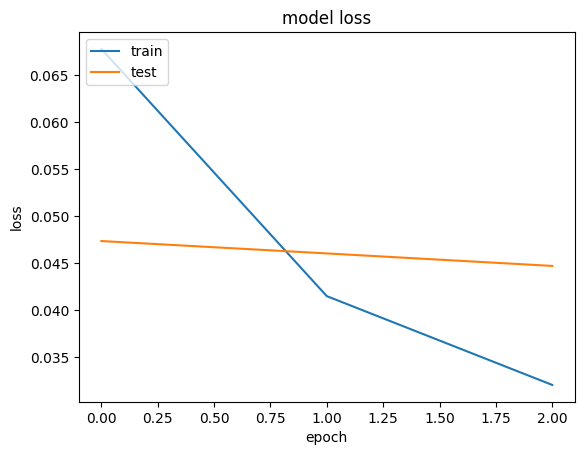

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
f.close()
test_data = Dataset.from_pandas(df)

In [12]:
df.head()

,news,masked headline,calculation,ans,text
0,Police are still hunting for an armed and da...,<extra_id_0> rd Victim Dead in Quarry Shooting...,Trans(three),3,Police are still hunting for an armed and da...
1,The New York Times followed the Best Picture ...,NYT Corrects 1853 Piece After <extra_id_0> Ye...,Copy(12),12,The New York Times followed the Best Picture ...
2,Stocks rallied on Election Day as investors a...,Stocks Up <extra_id_0> in Election Rally </s>,"Round(305.45,0)",305,Stocks rallied on Election Day as investors a...
3,Turns out you won't even have to leave your h...,You Can Watch The Interview at <extra_id_0> pm...,Copy(1),1,Turns out you won't even have to leave your h...
4,"Tristen Kurilla, the Pennsylvania 10-year-old...","Murder Suspect, <extra_id_0> , Will Stay in Ad...",Copy(10),10,"Tristen Kurilla, the Pennsylvania 10-year-old..."


In [7]:
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['calculation']

    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=350, num_beams=5, early_stopping=True)


    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    return results.split('<')[0]        

In [8]:
cal = []
for i in test_data:
    cal.append(t5_predictions(i, tokenizer, model))


2023-11-28 15:00:32.573209: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5a180034c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 15:00:32.573276: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-28 15:00:32.573283: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-28 15:00:32.578535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 15:00:32.601655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-11-28 15:00:32.609694: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-11-28 15:00:32.816574: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [9]:
df1 = pd.DataFrame()
df1['calc'] = cal
df1.to_excel('Lamini28.xlsx')

In [17]:
cal = pd.read_excel('Lamini28.xlsx')

In [10]:
false=0
for x,y in zip(test_data['calculation'], cal):
    if x != y:
        false +=1
false

445

In [18]:
def t5_predictions2(data, tokenizer, model):


    inputs = tokenizer.encode_plus(data, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=64, num_beams=5, early_stopping=True)


    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    res = re.findall(r"([\d:,./]+)", results)
    return res[0]

In [19]:
false=0
pred = []
for x,y in zip(cal['calc'], test_data['ans']):
    ans = t5_predictions2(x, tokenizer, model2)
    pred.append(ans)
    if ans != y:
        print(ans)
        print(y)
        print("")
        false += 1


2023-11-28 18:44:42.167091: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe358030310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 18:44:42.167135: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-28 18:44:42.167142: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-28 18:44:42.171495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 18:44:42.194809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-11-28 18:44:42.202266: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-11-28 18:44:42.386967: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
161
12

5
9

1.29
1

1.1
2

2009
2000

300
285

10
2

150
60

5
59

4
4.5

17.4
350

28
31

2
47

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
79.5
160

3
4

24
85

121
1892

2
17

1
6

28
2

364
12

4
26

91
62

3.7
3

1
2

8
10

10
15.5

109
100

4
2

50.9
6

26
27

200
800

10
9

28
28.6

24
2

3.1
3

239
230

1.5
20

3
1

513
500

2012
2010

6
51

2
3

5
1981

915
900

1,068
1,000

169,000


In [20]:
false

252

In [21]:
1-false/len(test_data['ans'])

0.9020217729393468

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(df['ans'], pred)

0.9020217729393468

In [24]:
with open('predictions.txt', 'w+') as f:
     
    for prediction in pred:
        f.write('%s\n' %prediction)
     
f.close()